# Pulsar detection 

## Introduction
### Background information

A pulsar is a celestial body which emits precise amounts of electromagnetic radiation. It is highly sought after by astrophysicists as it is the only place where they can observe matter indirectly at nuclear density. 



### Question?


Can we build an accurate classifier to distinguish pulsars from other celestial bodies?



### Dataset

The utilized dataset is [HTRU2 Data Set](https://archive.ics.uci.edu/ml/datasets/HTRU2) collected by Dr Robert Lyon, University of Manchester. 

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Class,Count,IQRMeanDM_SNRcurve,MedianSdDM_SNRcurve,MeanExcessKurtosisDM_SNRcurve,MeanSkewnessDM_SNRcurve
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
0,12161,2.345318,6.387041,8.892791,113.97371
1,1262,64.357023,19.206910,2.747644,17.84025


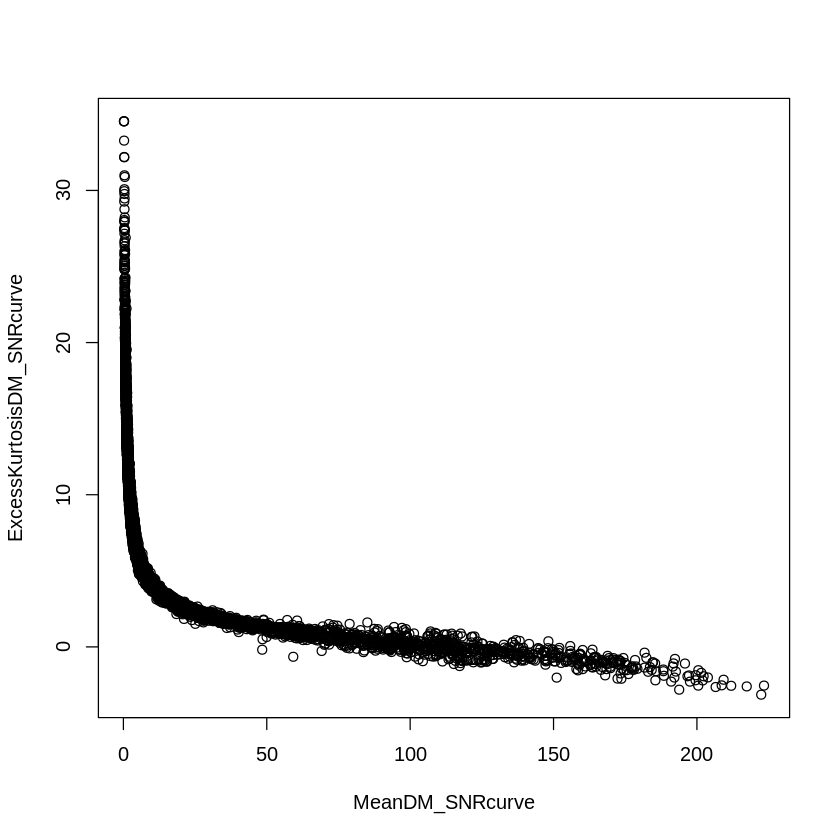

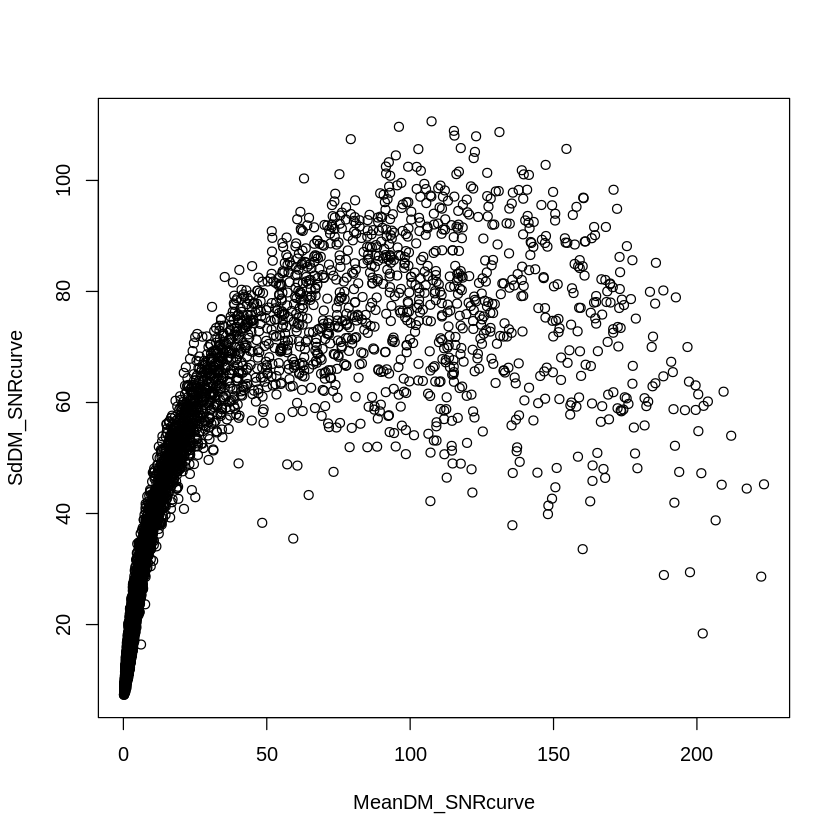

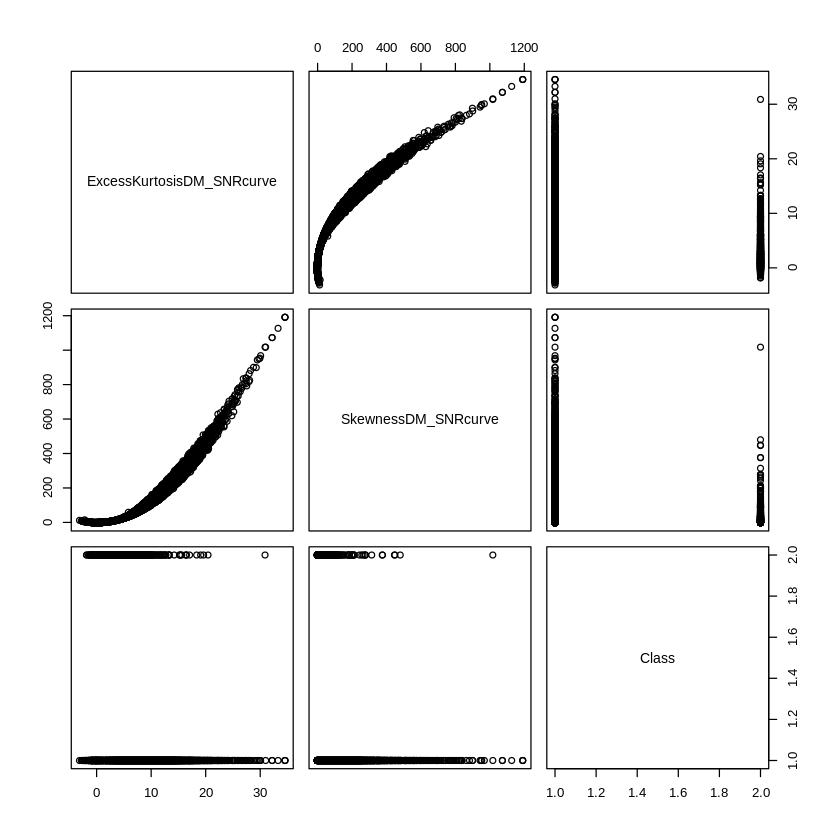

In [36]:
# loading dependencies
library(tidyverse)
library(tidymodels)

######################################### showing that the data can be read and tidying the data
############################################################################################################



# loading the data
pulsarData <- read_csv("HTRU_2.csv", col_names = FALSE)

colnames(pulsarData) <- c("MeanIntegratedprofile", # X1
                           "SdIntegratedProfile",   # X2
                           "ExcessKurtosisIntegratedProfile", # X3
                           "SkewnessIntegratedProfile", #X4
                           "MeanDM_SNRcurve", # X5
                           "SdDM_SNRcurve",  #X6
                           "ExcessKurtosisDM_SNRcurve", #X7
                           "SkewnessDM_SNRcurve", #X8
                           "Class") #X9
pulsarData = mutate(pulsarData, Class = as.factor(Class))



########################################## Dividing the data into training data and validating data
############################################################################################################

pulsarSplit <- initial_split(pulsarData, prop = 0.75, strata = Class)
pulsarTrain <- training(pulsarSplit)
pulsarTesting <- testing(pulsarSplit)

pulsarTrain %>% group_by(Class) %>% summarize(Count = n(), 
                                              IQRMeanDM_SNRcurve = IQR(MeanDM_SNRcurve), 
                                              MedianSdDM_SNRcurve = mad(SdDM_SNRcurve), 
                                              MeanExcessKurtosisDM_SNRcurve = mean(ExcessKurtosisDM_SNRcurve),
                                              MeanSkewnessDM_SNRcurve = mean(SkewnessDM_SNRcurve))

plot(select(pulsarTrain, 5,7))
plot(select(pulsarTrain, 5,6))
plot(select(pulsarTrain, 7,8,9))


In [32]:
pulsarTrain$[4:9]

ERROR: Error in parse(text = x, srcfile = src): <text>:1:13: unexpected '['
1: pulsarTrain$[
                ^


In [31]:
?plot

plot {base},R Documentation
x,"the coordinates of points in the plot. Alternatively, a single plotting structure, function or any R object with a plot method can be provided."
y,"the y coordinates of points in the plot, optional if x is an appropriate structure."
...,"Arguments to be passed to methods, such as graphical parameters (see par). Many methods will accept the following arguments: typewhat type of plot should be drawn. Possible types are ""p"" for points, ""l"" for lines, ""b"" for both, ""c"" for the lines part alone of ""b"", ""o"" for both ‘overplotted’, ""h"" for ‘histogram’ like (or ‘high-density’) vertical lines, ""s"" for stair steps, ""S"" for other steps, see ‘Details’ below, ""n"" for no plotting. All other types give a warning or an error; using, e.g., type = ""punkte"" being equivalent to type = ""p"" for S compatibility. Note that some methods, e.g. plot.factor, do not accept this. mainan overall title for the plot: see title. suba sub title for the plot: see title. xlaba title for the x axis: see title. ylaba title for the y axis: see title. aspthe y/x aspect ratio, see plot.window."
